## Seasonal Time series

### Test of stationarity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-talk')

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf,pacf,adfuller

In [2]:

def test_stationarity(timeseries,maxlag=12):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag=None,maxlag=maxlag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
datasets = pd.read_excel('../Data/TB_nation.xlsx',index_col='Date')
datasets_pred = datasets[datasets.index>='2014-01-1']
datasets = datasets[datasets.index<'2014-01-01']
datasets.shape

(108, 7)

In [4]:
datasets.head()

,Area,Incidence,Death,Incidence_rate,Death_rate,Year,Month
Date,,,,,,,
2005-01-01,全 国,114194,143,8.784966,0.011001,2005,1
2005-02-01,全 国,87112,201,6.701542,0.015463,2005,2
2005-03-01,全 国,130134,281,10.011233,0.021617,2005,3
2005-04-01,全 国,133924,374,10.302798,0.028772,2005,4
2005-05-01,全 国,121326,388,9.333632,0.029849,2005,5


### Seasonal difference

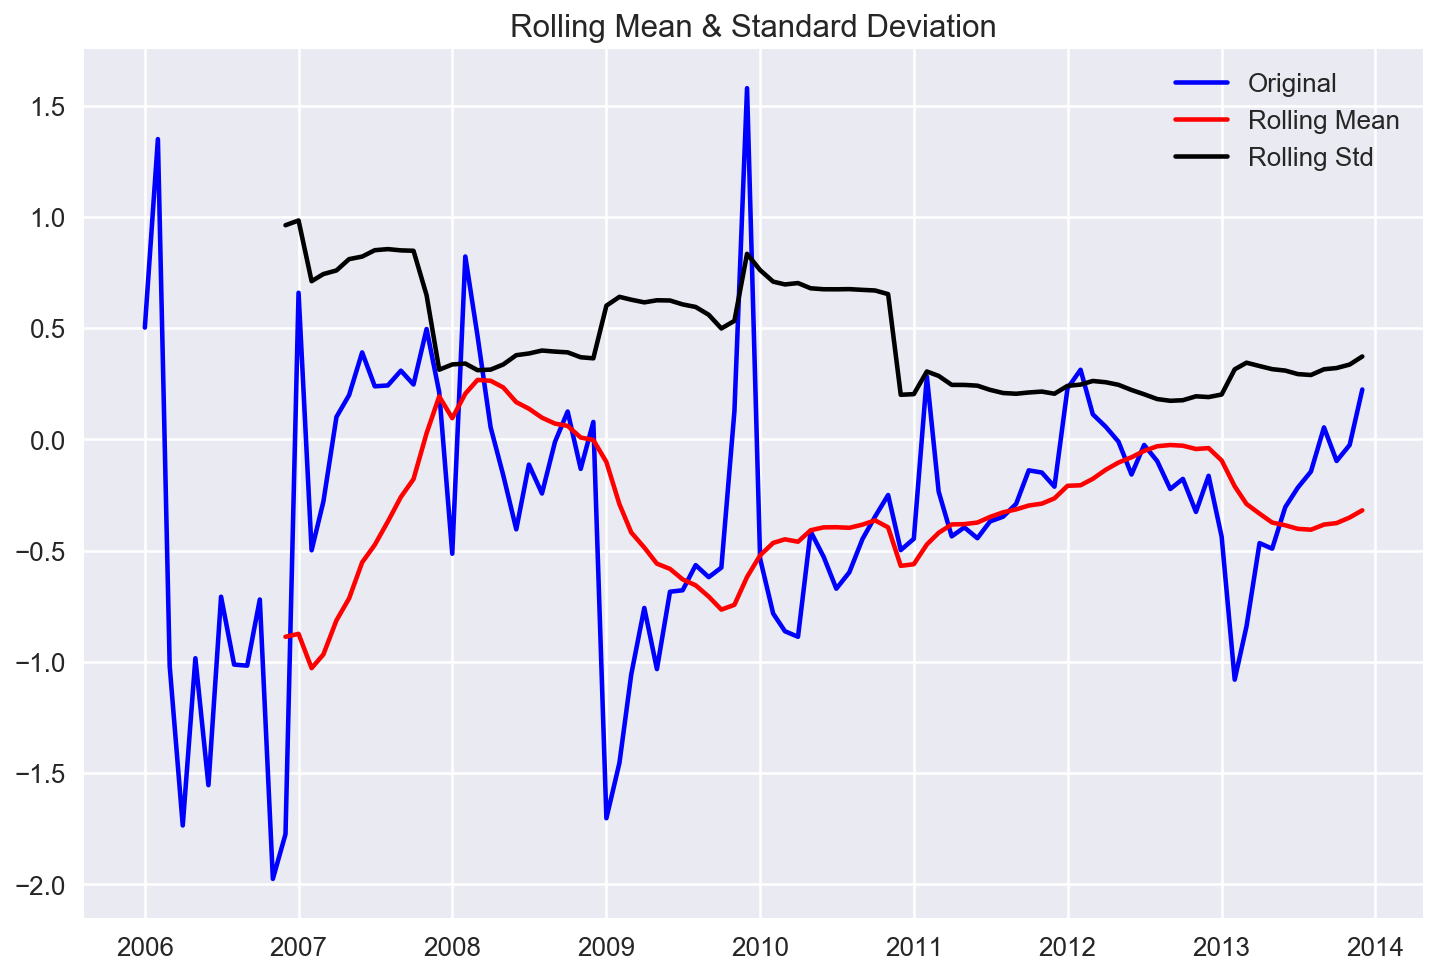

Results of Dickey-Fuller Test:
Test Statistic                 -3.036272
p-value                         0.031643
#Lags Used                      6.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [5]:
datasets['seasonal_difference'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(12)  
test_stationarity(datasets.seasonal_difference.dropna(inplace=False),maxlag=6)

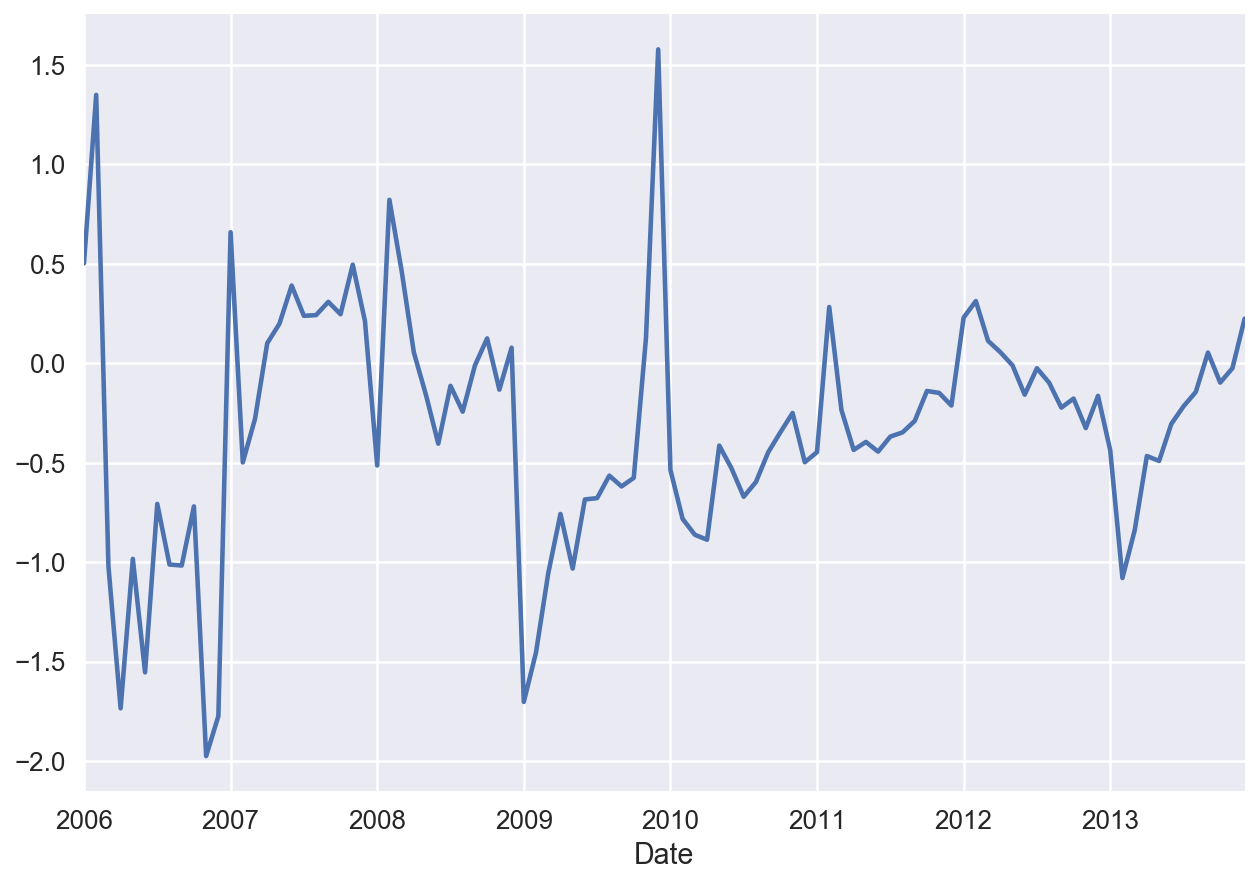

In [6]:
datasets.seasonal_difference.dropna(inplace=False).plot()

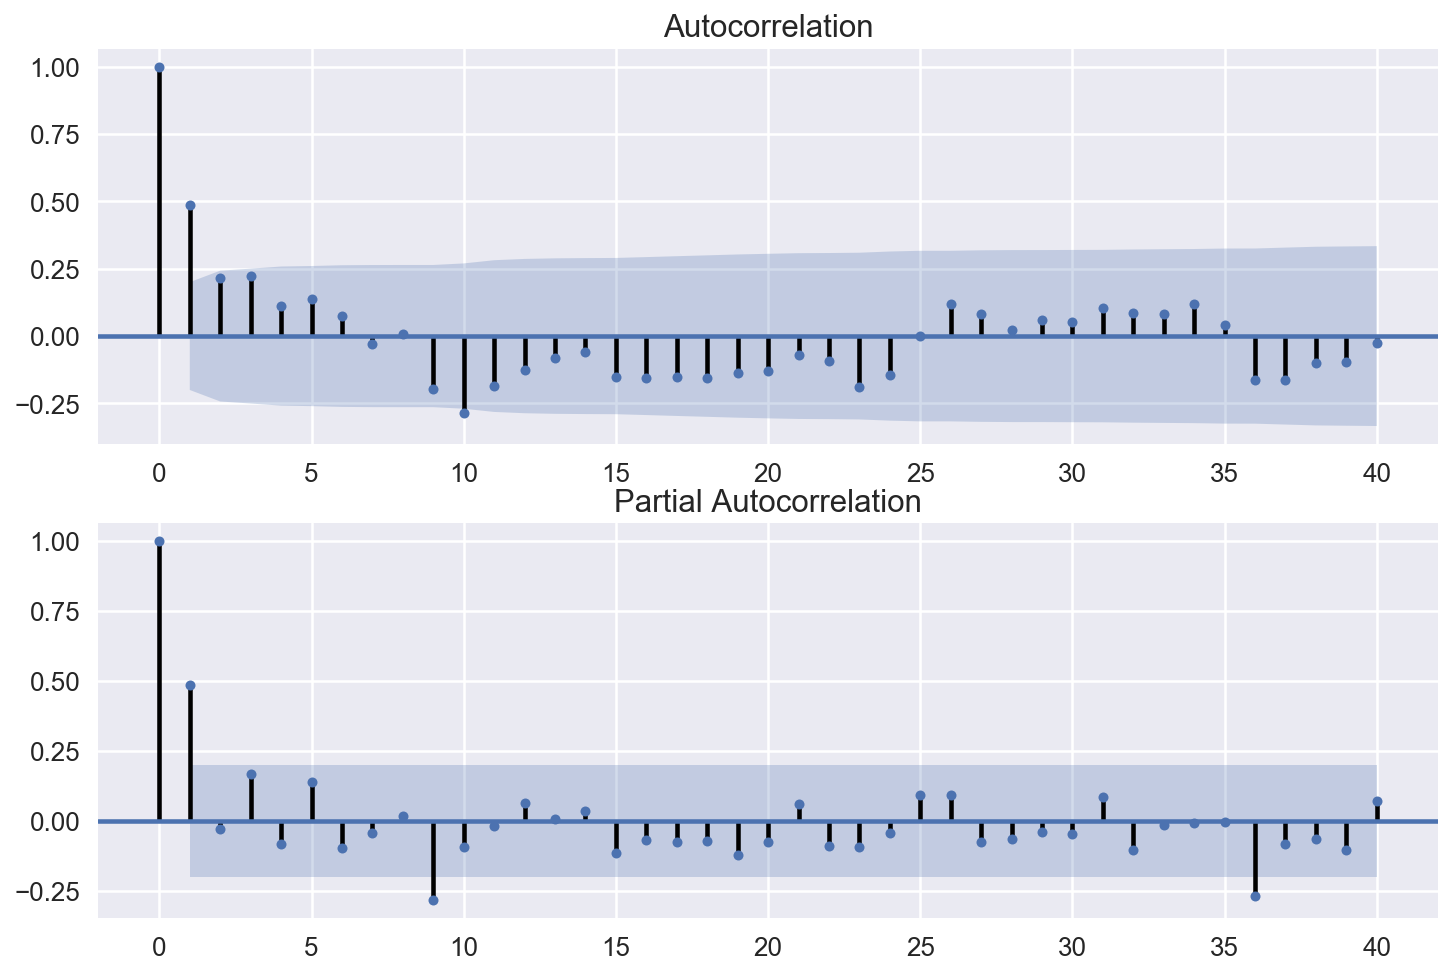

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_difference.iloc[12:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_difference.iloc[12:], lags=40, ax=ax2)
fig.savefig('ACF-PACF.png',dpi=300)

In [28]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(1,0,0), seasonal_order=(0,1,0,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 -76.576
Date:                            Sun, 19 Mar 2017   AIC                            157.151
Time:                                    16:19:18   BIC                            162.516
Sample:                                01-01-2005   HQIC                           159.326
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6024      0.061      9.909      0.000       0.483       0.722
sigma2         0.2873      0.028   

In [34]:
? sm.tsa.SARIMAX

### Plot

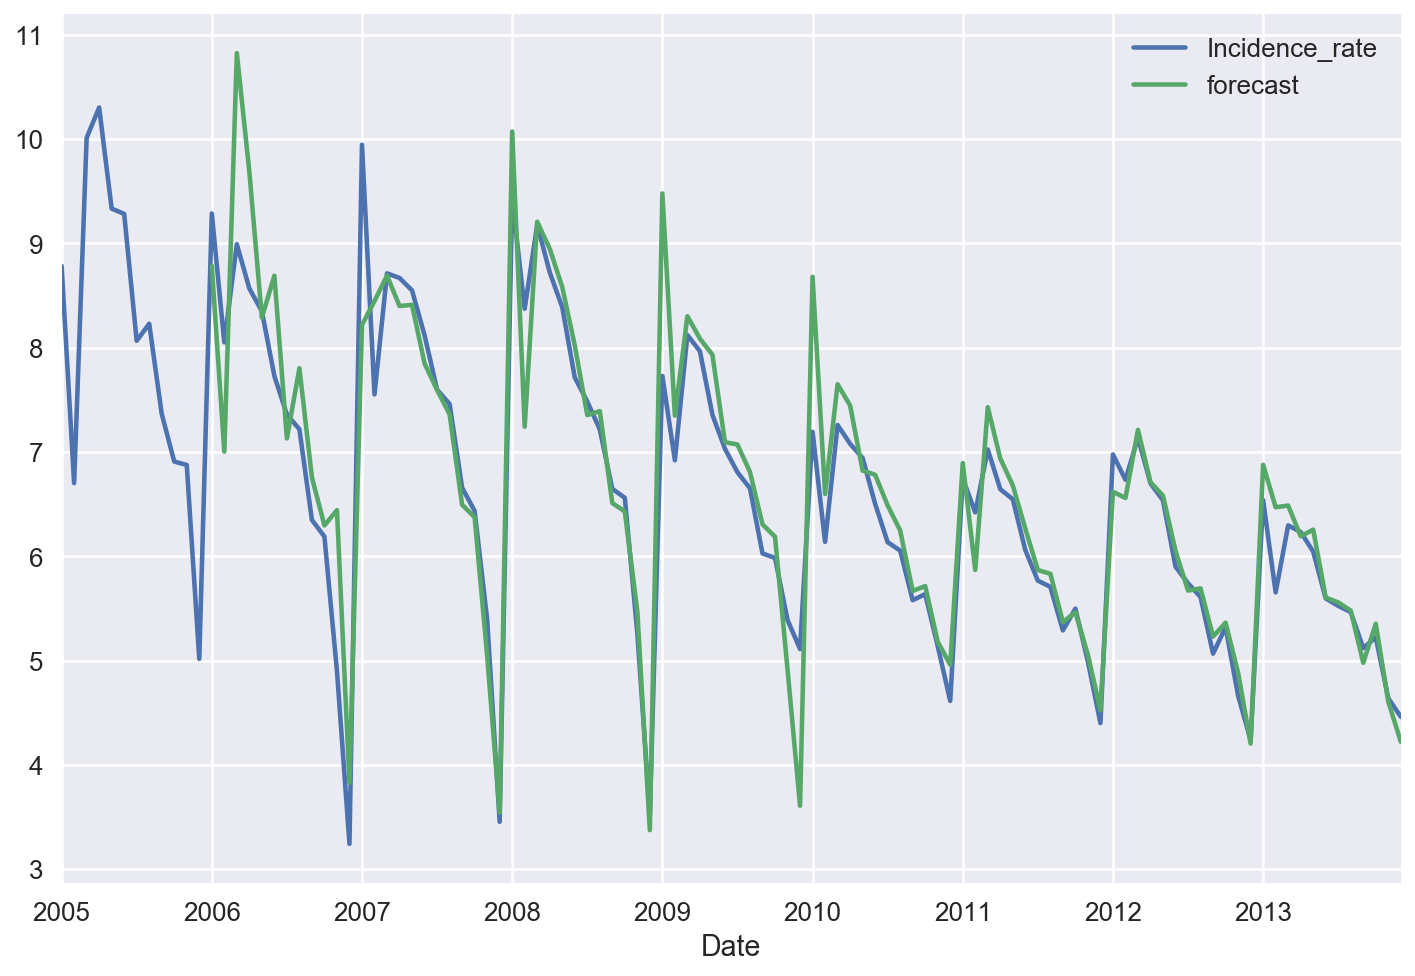

In [36]:
datasets['forecast'] = results.predict(start = 12, end= 131, dynamic= False)  
datasets[['Incidence_rate', 'forecast']].plot(figsize=(12, 8))

In [37]:
dta = pd.concat([datasets, datasets_pred])[['Death','Death_rate','Incidence','Incidence_rate','forecast','Year','Month']]
dta['forecast'] = results.predict(start=12,end=131,dynamic=False)
dta.tail(13)

,Death,Death_rate,Incidence,Incidence_rate,forecast,Year,Month
Date,,,,,,,
2013-12-01,195,0.014401,60399,4.460651,4.221439,2013,12
2014-01-01,189,0.013947,89128,6.576894,6.673836,2014,1
2014-02-01,178,0.013135,77153,5.693240,5.735268,2014,2
2014-03-01,214,0.015791,84473,6.233394,6.345317,2014,3
2014-04-01,230,0.016972,81543,6.017185,6.262331,2014,4
2014-05-01,212,0.015644,79530,5.868642,6.062793,2014,5
2014-06-01,182,0.013430,76366,5.635166,5.606478,2014,6
2014-07-01,184,0.013578,74607,5.505367,5.531027,2014,7
2014-08-01,188,0.013873,71144,5.249826,5.468642,2014,8


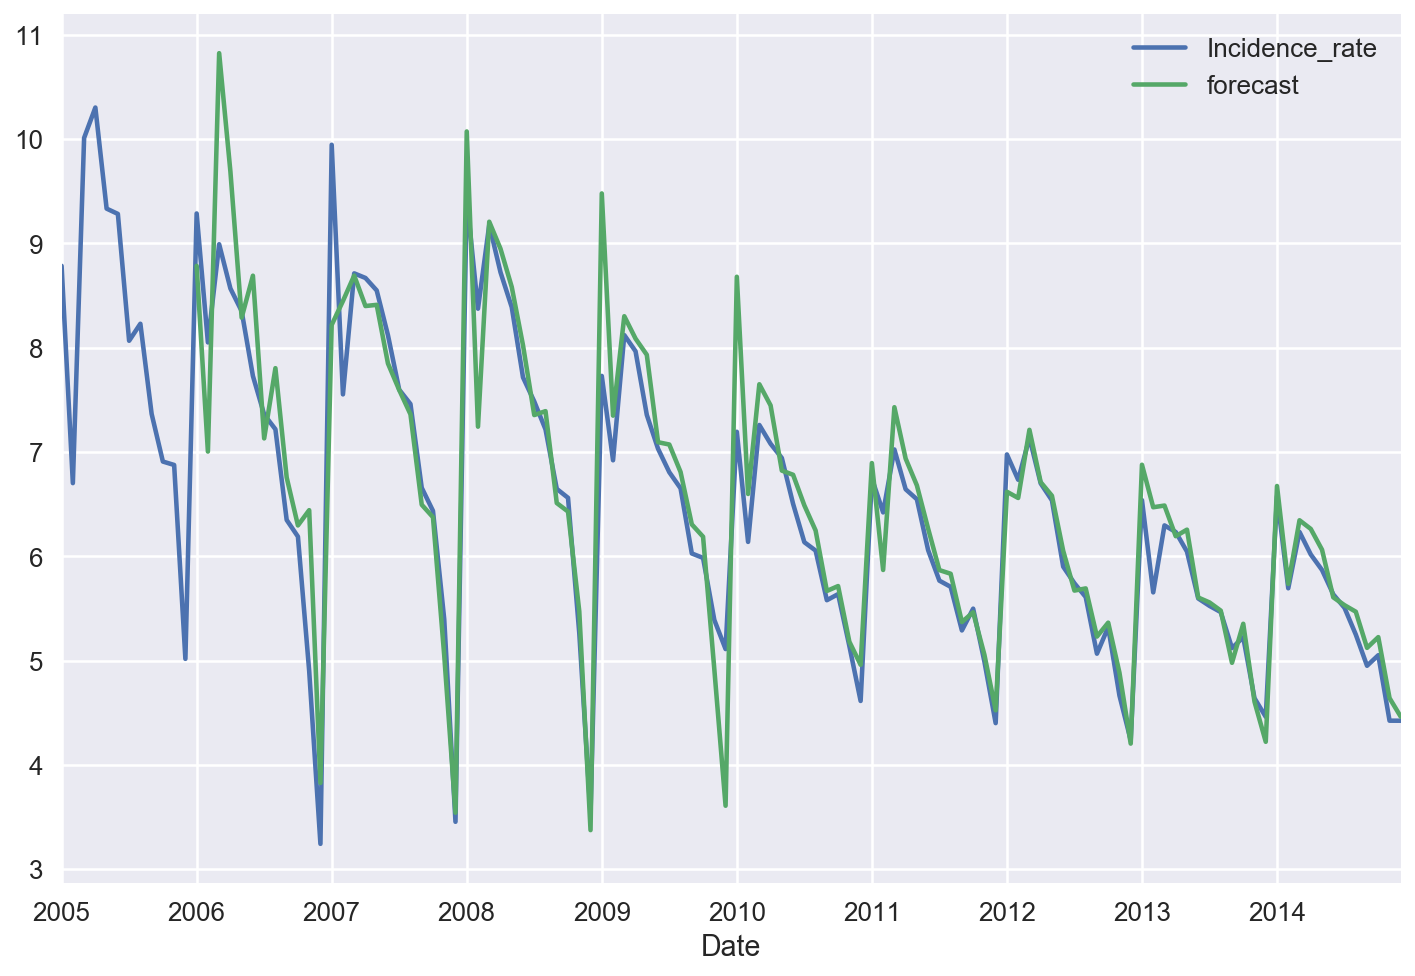

In [38]:
dta['forecast'] = results.predict(start = 12, end= 131, dynamic= False)  
dta[['Incidence_rate','forecast']].plot(figsize=(12, 8))

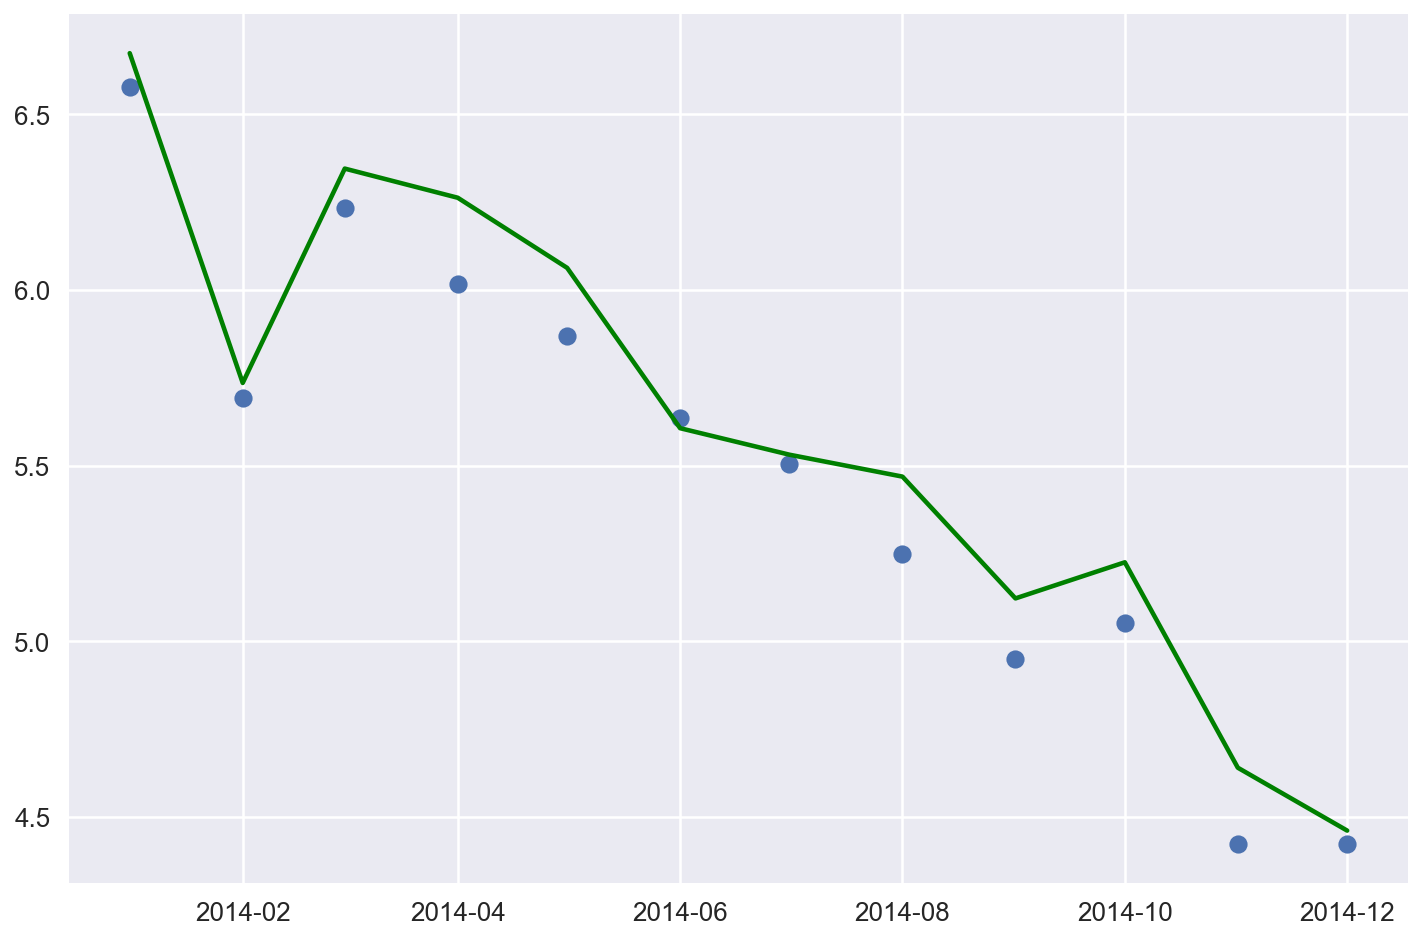

In [70]:
fig = plt.figure(figsize=(12,8))
plt.plot(dta.loc['2014-01-01':,'Incidence_rate'],'o')
plt.plot(dta.loc['2014-01-01':,'forecast'],'g')
fig.savefig('predict.png')

13.331473395093191

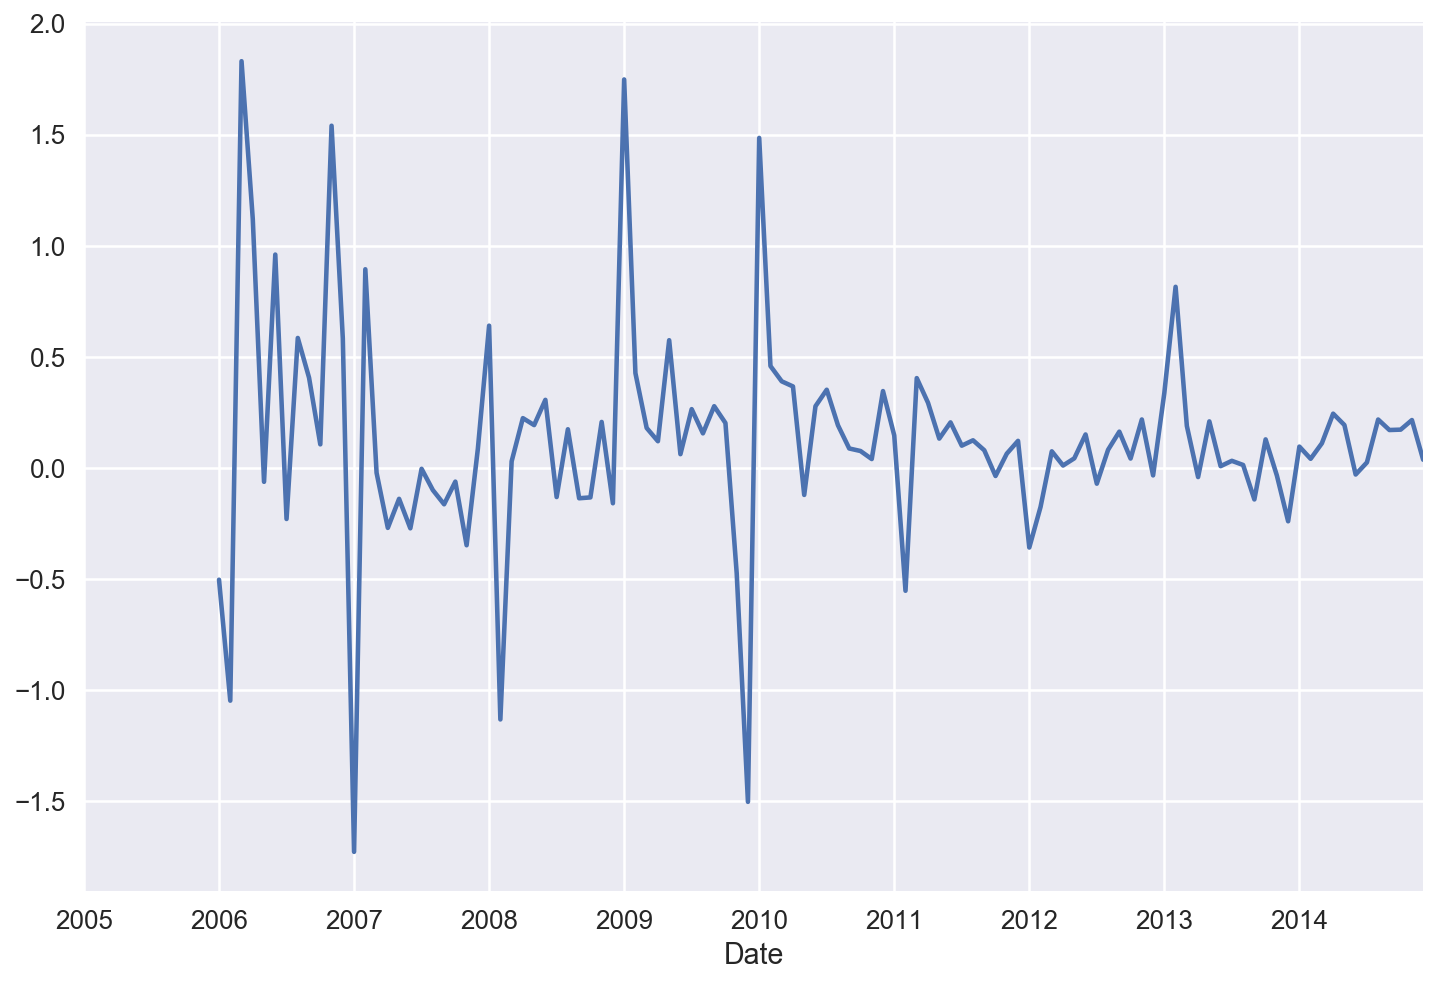

In [71]:
dta['error_ARIMA'] = dta['forecast']-dta['Incidence_rate']
dta['error_ARIMA'].plot(figsize=(12,8))
sum(dta['error_ARIMA'].dropna())

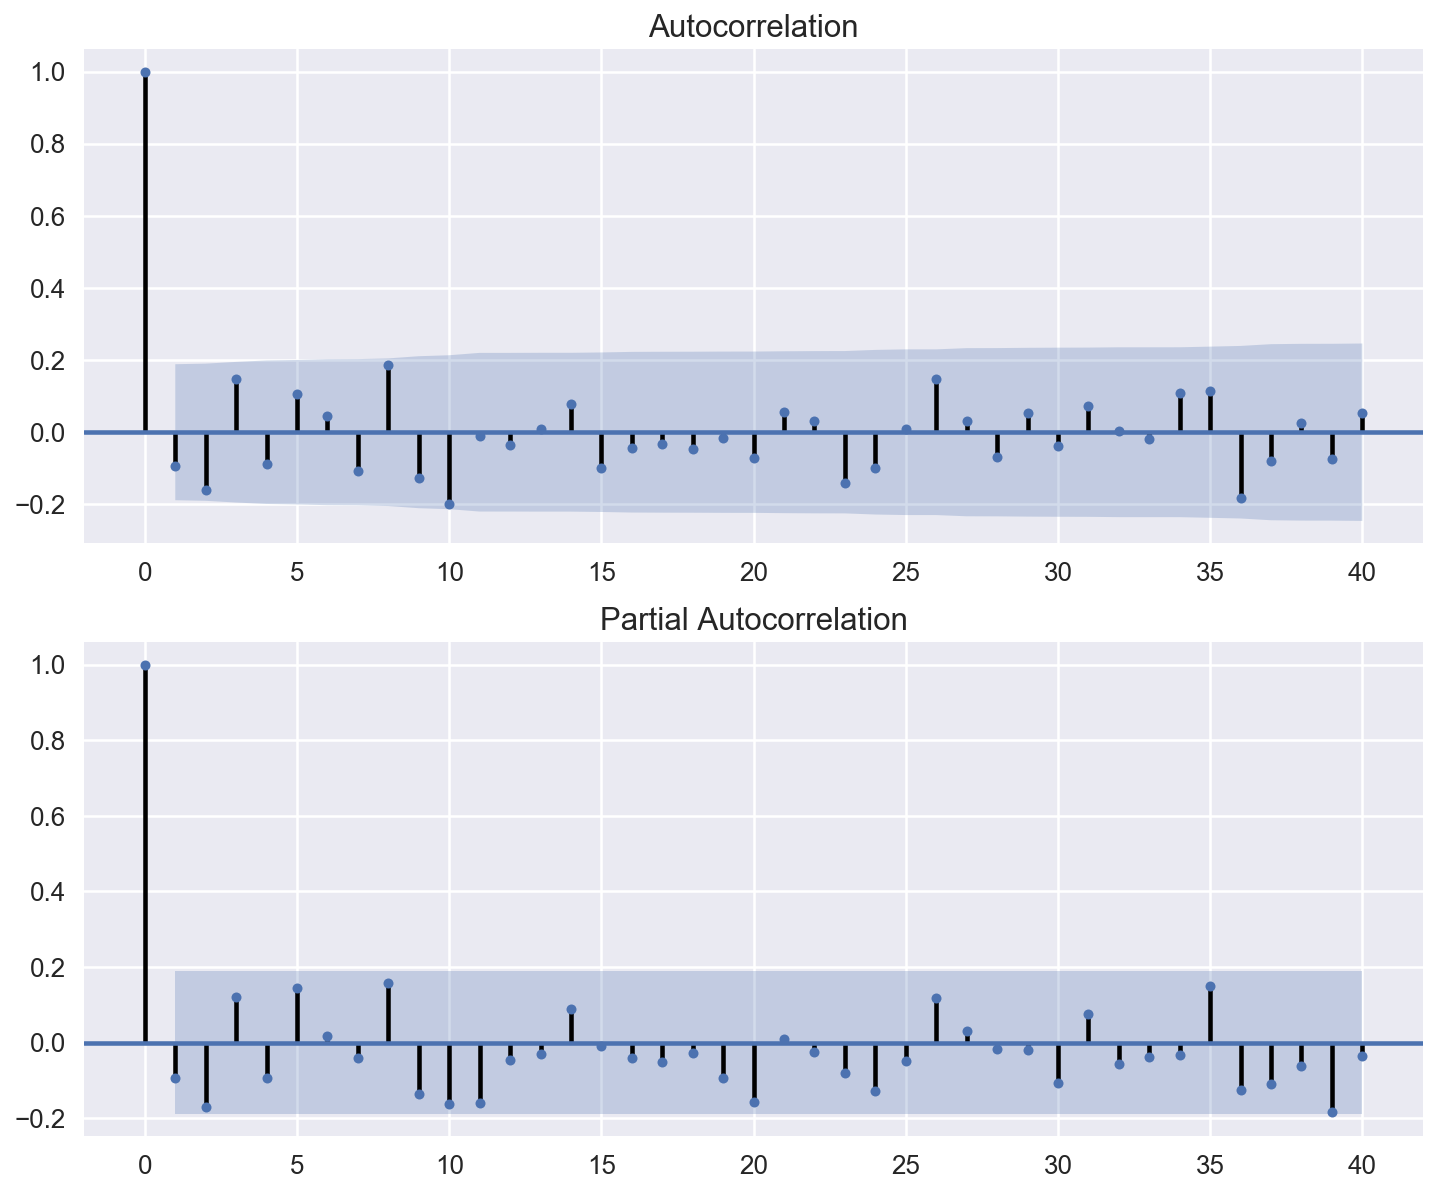

In [33]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.error_ARIMA.iloc[12:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.error_ARIMA.iloc[12:], lags=40, ax=ax2)
fig.savefig('residual.png',dpi=300)

In [72]:
dta.to_excel('../Data/Seasonal.xlsx')